In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from wordcloud import WordCloud
import gensim
from gensim import corpora, models
from pprint import pprint
from textblob import TextBlob

%matplotlib inline 

In [2]:
main = pd.read_csv('/Volumes/ML_projects/Phase4data/appletweet.csv', index_col=0)

In [3]:
main.drop_duplicates(subset='c_tweet', inplace=True)
main = main.drop(columns=['place', 'timezone', 'time', 'user_id', 'name'])

In [4]:
main.dropna(inplace=True)

In [5]:
main.shape

(983566, 12)

# Sentiment Distribution (Overall)

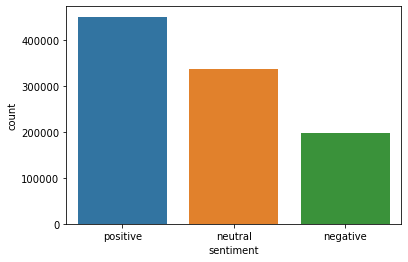

In [6]:
sns.countplot(main.sentiment);

# Sentiment Over Time

In [7]:
#Make a copy of the df for time series graphs.
time_series_df = main.copy()
time_series_df['date'] = pd.to_datetime(time_series_df['date'])
time_series_df.set_index(['date', 'sentiment'], inplace=True)

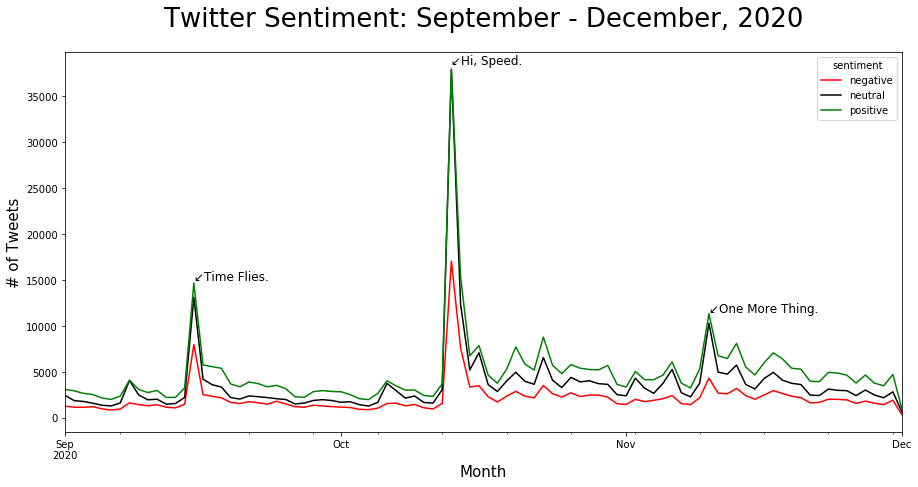

In [84]:
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
time_series_df.groupby(['date','sentiment']).count()['c_tweet'].unstack().plot(ax=ax,color=('red','black', 'green'));

ax.annotate("↙Time Flies.", xy=(pd.Timestamp('2020-9-15'), 15000), fontsize=12)
ax.annotate("↙Hi, Speed.", xy=(pd.Timestamp('2020-10-13'), 38500), fontsize=12)
ax.annotate("↙One More Thing.", xy=(pd.Timestamp('2020-11-10'), 11500), fontsize=12)
plt.xlabel('Month', size=15) 
plt.ylabel('# of Tweets', size=15)
ax.set_title('Twitter Sentiment: September - December, 2020', fontsize=26, pad='25.0');
plt.savefig('sentiment_over_time.png')

In [64]:
sent_change = main.copy()
sent_change.reset_index(inplace=True, drop=True)

In [85]:
#everything before october 13
before_oct_13 = sent_change.loc[:'2020-10-13'].sentiment.value_counts()
neutral_before = before_oct_13[0]
positive_before = before_oct_13[1]
negative_before = before_oct_13[2]

avg_pos_reviews_before = (negative_before)/(neutral_before + positive_before + negative_before)
avg_pos_reviews_before

0.18306930693069307

In [86]:
#everything after october 13
after_oct_13 = sent_change.loc['2020-10-13':].sentiment.value_counts()
neutral_after = after_oct_13[0]
positive_after = after_oct_13[1]
negative_after = after_oct_13[2]

avg_pos_reviews_after = (negative_after)/(neutral_after + positive_after + negative_after)
avg_pos_reviews_after

0.2056115542385416

# Search term rank

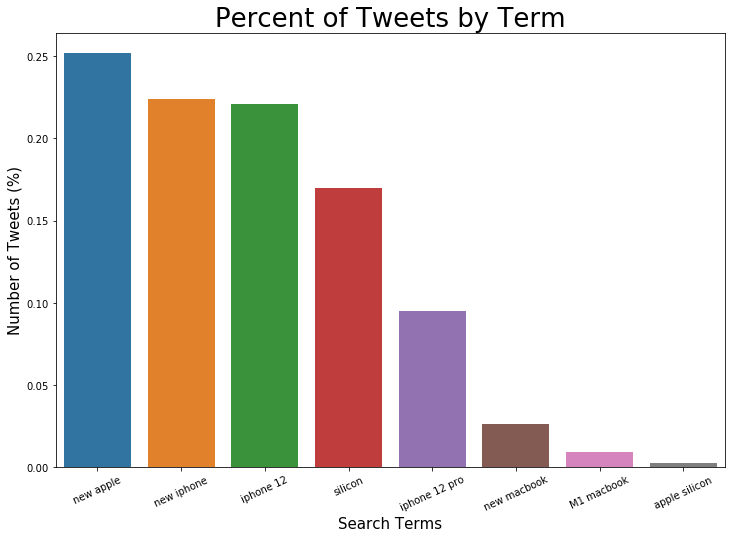

In [93]:
x=main["search_term"].value_counts().index.to_list()
y = main["search_term"].value_counts(normalize=True).to_list()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=x, y=y)
plt.title("Percent of Tweets by Term", fontsize=26)
plt.xlabel("Search Terms", fontsize=15)
plt.ylabel("Number of Tweets (%)", fontsize=15)
plt.xticks(rotation=25);
plt.savefig('tweet_count_by_term.png')

# Frequency Distribution of Words

In [85]:
filt = main.delisted

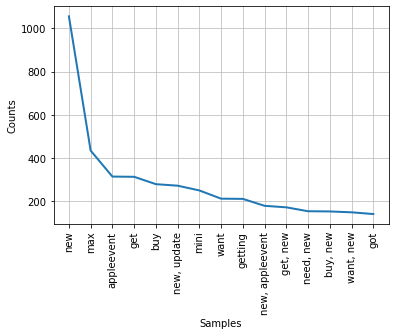

In [86]:
fdist=FreqDist(filt)
fdist.plot(15);

# Sentiment by Search Term

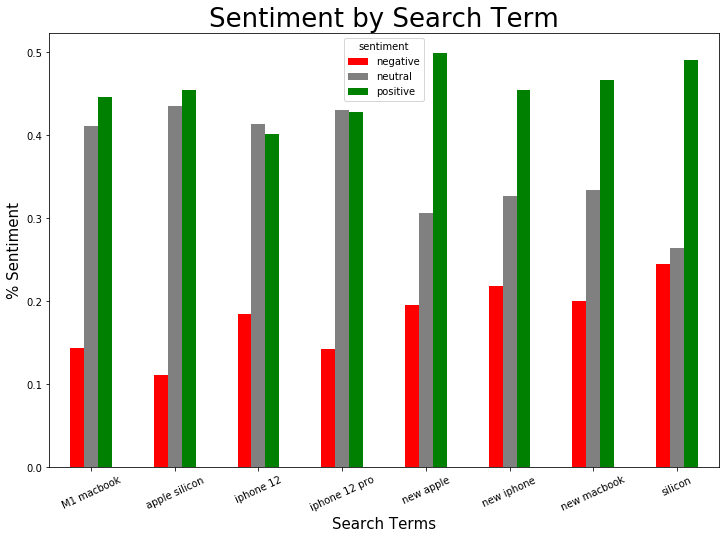

In [92]:
y = main.groupby("search_term")["sentiment"].value_counts(normalize=True).unstack()
y.plot(kind = 'bar', figsize=(12,8), color =["red", "grey", "green"])
plt.xticks(rotation=25)
plt.title("Sentiment by Search Term", fontsize=26)
plt.xlabel("Search Terms", fontsize=15)
plt.ylabel("% Sentiment", fontsize=15);
plt.savefig('sentiment_by_term.png')

# Word Cloud ☁️

In [121]:
cloud = main.drop_duplicates(subset=['filtered'])
text = cloud.delisted

In [122]:
text = " ".join(tweet for tweet in text)

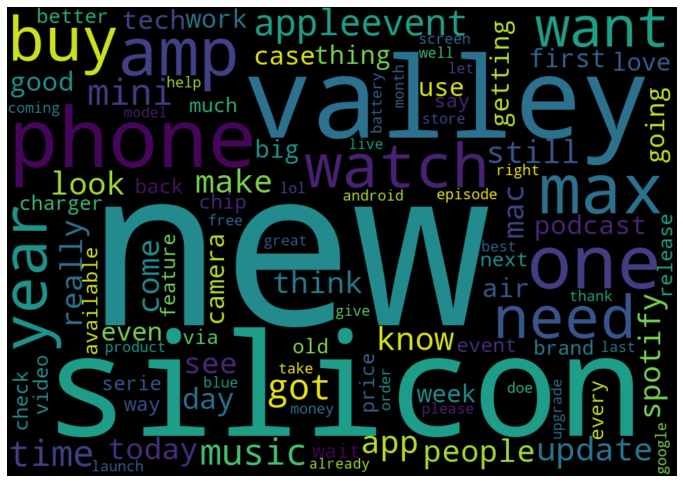

In [252]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=100,collocations=False, width=1000, height=700, background_color="black").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()
wordcloud.to_file('all_tweets_wordcloud.png')

In [211]:
import nltk
from nltk.corpus import stopwords

In [204]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = nltk.tokenize.TweetTokenizer()

def lemmatize_text(text):
     return [lemmatizer.lemmatize(word.replace(" ", "")) for word in tokenizer.tokenize(text)]
#    return [stemming.stem(word) for word in tokenizer.tokenize(text)]

def unlist(x):
    return ", ".join(x)

In [207]:
stop_words=list(set(stopwords.words("english")))

stop_words.extend(["ll", "please retweet", "help rt", "visit us", "please subscribe", "for sale", "enter here", "to win", "from iphone", "huge giveaway", "new arrival", "win an", "unlocked now", "new available", "giveaway", "subscribe", "retweet", "easter egg"])

eda_stopwords = ["iphone", "iphone pro", "pro max", "youtube", "youtuber", "youtubers", 
                 "also", "asap", "hmmm","hello", "haha", "dont", "imac", "ipad", 
                 "ipadair", "ipads", "iphonecase", "iphonemini", "iphonepro", "iphonepromax", 
                 "iphones", "iphoneth", "ipod", "pro", "max",  "lmao", "lmfao", "macbook", "macbookair",
                 "macbookpro", "macbooks", "macosbigsur", "macmini", "magsafe", 
                 "okay", "promax", "wahala", "wont", 'yall','yeah',]

stop_words.extend(eda_stopwords)

In [208]:


#tokenize and lemmatize words
main["cleaned"] = main.c_tweet.apply(lemmatize_text)

# removes stopwords from the cleaned texts
main["not_filtered"] = main['cleaned'].apply(lambda x: [item for item in x if item not in stop_words and len(item)>1])

main["filtered"] = main.not_filtered.apply(unlist)

In [209]:
main.head(3)

,date,username,tweet,replies_count,retweets_count,likes_count,search_term,c_tweet,tokenized,filtered,delisted,sentiment,cleaned,not_filtered
5,2020-12-01,coolmuster,#iPhone12 #Android iPhone 12 vs Android’s best...,0.0,0.0,0.0,iphone 12,iphone android iphone vs android best it time ...,"['iphone', 'android', 'iphone', 'v', 'android'...","android, android, best, time, consider, switch...","android, android, best, time, consider, switch...",positive,"[iphone, android, iphone, v, android, best, it...","[android, android, best, time, consider, switc..."
6,2020-12-01,nanaakuamensah4,@cuppymusic I'm asking DJ cuppy Please I want ...,0.0,0.0,0.0,iphone 12,asking dj cuppy please want an iphone,"['asking', 'dj', 'cuppy', 'please', 'want', 'a...","asking, dj, cuppy, please, want","asking, cuppy, please, want",positive,"[asking, dj, cuppy, please, want, an, iphone]","[asking, dj, cuppy, please, want]"
15,2020-12-01,naija_pr,The moment Mercy Eke sprays her friend $3000 c...,0.0,1.0,3.0,iphone 12,the moment mercy eke sprays her friend cash an...,"['the', 'moment', 'mercy', 'eke', 'spray', 'he...","moment, mercy, eke, spray, friend, cash, gave,...","moment, mercy, eke, spray, friend, cash, gave,...",positive,"[the, moment, mercy, eke, spray, her, friend, ...","[moment, mercy, eke, spray, friend, cash, gave..."


# Bag of Words on Filtered Columns

In [213]:
import gensim

In [212]:
#Dataframe enables dictionary for word BoW
apple_tweets = main["not_filtered"]

In [214]:
#This will tag every unique word in apple_tweets and give it an 'id' number. 
dictionary = gensim.corpora.Dictionary(apple_tweets)

In [217]:
#confirming output of the word tags
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10: #only displaying first 10 
        break
print('Total length of word/id pairs: {}'.format(len(dictionary)))

0 android
1 best
2 consider
3 phone
4 switching
5 time
6 asking
7 cuppy
8 dj
9 please
10 want
Total length of word/id pairs: 242439


In [220]:
# dictionary is then filtered to remove that appear in more than 50% 
dictionary.filter_extremes(no_above=0.5)
print('Total length of word/id pairs after filtering commonly repeated words across all documents in the corpus: {}'.format(len(dictionary)))

Total length of word/id pairs after filtering commonly repeated words across all documents in the corpus: 46152


In [222]:
# applying the dictionary to the apple tweets to create a sparce matrix/vector (BOW)
sparse_matrix = [dictionary.doc2bow(doc) for doc in apple_tweets]

In [225]:
# Creating the Bag of Words:

bow = pd.DataFrame(sparse_matrix)
bow.head(3)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,"(0, 2)","(1, 1)","(2, 1)","(3, 1)","(4, 1)","(5, 1)",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"(6, 1)","(7, 1)","(8, 1)","(9, 1)","(10, 1)",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"(11, 1)","(12, 1)","(13, 1)","(14, 1)","(15, 1)","(16, 1)","(17, 1)","(18, 1)",None,None,...,None,None,None,None,None,None,None,None,None,None


In [229]:
print('Original Tweet: {}\n'.format(main.c_tweet.iloc[6]))

bow_doc = sparse_matrix[6]
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], 
                                               dictionary[bow_doc[i][0]], 
                                                bow_doc[i][1]))
#*with stop words removed.

Original Tweet: cuppy give iphone na cuppydat

Word 7 ("cuppy") appears 1 time.
Word 44 ("cuppydat") appears 1 time.
Word 45 ("give") appears 1 time.
Word 46 ("na") appears 1 time.


# TFIDF Corpus

In [232]:
tfidf = models.TfidfModel(sparse_matrix)
corpus_tfidf = tfidf[sparse_matrix]

In [234]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6082344654474792),
 (1, 0.303896789170335),
 (2, 0.47351665890450484),
 (3, 0.1846144645592721),
 (4, 0.4716070132825108),
 (5, 0.23871295484731836)]


# LDA Model 

Running LDA model on the TFIDF generated corpus.

In [240]:
%%time
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10, workers=8, random_state=1)

CPU times: user 24min 46s, sys: 2min 12s, total: 26min 59s
Wall time: 29min 6s


In [241]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n\Word: {}\n'.format(idx, topic))

Topic: 0 
\Word: 0.016*"phone" + 0.013*"get" + 0.010*"like" + 0.010*"one" + 0.009*"need" + 0.009*"got" + 0.009*"want" + 0.009*"buy" + 0.008*"year" + 0.008*"getting"

Topic: 1 
\Word: 0.023*"appleevent" + 0.020*"apple" + 0.015*"event" + 0.012*"mac" + 0.011*"watch" + 0.010*"mini" + 0.009*"silicon" + 0.008*"air" + 0.008*"gb" + 0.008*"order"

Topic: 2 
\Word: 0.027*"music" + 0.019*"spotify" + 0.016*"episode" + 0.014*"apple" + 0.014*"podcast" + 0.012*"check" + 0.011*"live" + 0.011*"single" + 0.010*"listen" + 0.009*"amp"

Topic: 3 
\Word: 0.007*"please" + 0.006*"win" + 0.006*"silicon" + 0.006*"free" + 0.006*"get" + 0.005*"help" + 0.004*"apple" + 0.004*"brand" + 0.004*"one" + 0.004*"buy"

Topic: 4 
\Word: 0.020*"update" + 0.018*"io" + 0.011*"biden" + 0.009*"apple" + 0.007*"album" + 0.007*"silicon" + 0.007*"app" + 0.006*"widget" + 0.006*"feature" + 0.006*"blue"

Topic: 5 
\Word: 0.020*"charger" + 0.009*"charging" + 0.009*"usb" + 0.009*"headphone" + 0.008*"come" + 0.008*"box" + 0.007*"cable" + 

In [242]:
corpus_transformed = lda_model_tfidf[sparce_matrix]

Now we are going to label each tweet to the topic that it belongs too. 

In [269]:
%%time
# convert to dataframe
topics = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_tfidf_df = pd.DataFrame(topics)
# rename columns
lda_tfidf_df.rename(columns={i: f'topic{i}' for i in range(10)}, inplace=True)

lda_tfidf_df.tail()

CPU times: user 8min 3s, sys: 26.7 s, total: 8min 30s
Wall time: 8min 54s


In [270]:
#confirm shapes have not changed
print(len(main))
print(len(lda_tfidf_df))

983566
983566


In [271]:
#Transforming null values to 0
lda_tfidf_df.fillna(0, inplace=True)
lda_tfidf_df.tail()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
983561,0.011117,0.011113,0.011112,0.011113,0.011113,0.011112,0.011114,0.011112,0.011113,0.899983
983562,0.010003,0.010003,0.010004,0.010003,0.010004,0.010003,0.010004,0.010004,0.335537,0.584436
983563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240837,0.000000,0.460767,0.263384
983564,0.074419,0.000000,0.121982,0.000000,0.105343,0.000000,0.000000,0.054999,0.000000,0.621497
983565,0.194279,0.000000,0.000000,0.099069,0.000000,0.000000,0.000000,0.000000,0.281709,0.384913


# Concat lda_tfidf_df with main

In [324]:
main_df = pd.concat([lda_tfidf_df, main], axis = 1)
main_df.shape

(1759936, 24)

In [330]:
main_df.dropna(inplace=True)

In [331]:
#classifying if an observation was retweeted or not

yes_retweet = []
for x in main_df["retweets_count"]:
    if x >= 1:
        yes_retweet.append(1)
    else: 
        yes_retweet.append(0)
main_df["yes_retweets"] = yes_retweet
main_df.drop(columns = "retweets_count", inplace = True)

In [332]:
#classifying if an observation recieved likes or not
yes_likes = []
for x in main_df["likes_count"]:
    if x >= 1:
        yes_likes.append(1)
    else: 
        yes_likes.append(0)
main_df["yes_likes"] = yes_likes
main_df.drop(columns = "likes_count", inplace = True)

In [333]:
#classifying if an observation recieved replies
yes_replies = []
for x in main_df["replies_count"]:
    if x >= 1:
        yes_replies.append(1)
    else: 
        yes_replies.append(0)
main_df["yes_replies"] = yes_replies
main_df.drop(columns = "replies_count", inplace = True)

In [334]:
print('main shape: {}\nmain_df shape: {}'.format(main.shape, main_df.shape))

main shape: (983566, 14)
main_df shape: (207196, 24)


# Creating subjectivity score using Textblob

In [335]:
main_df['subjectivity_score'] = main_df['filtered'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [336]:
main_df.columns

Index(['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6',
       'topic7', 'topic8', 'topic9', 'date', 'username', 'tweet',
       'search_term', 'c_tweet', 'tokenized', 'filtered', 'delisted',
       'sentiment', 'cleaned', 'not_filtered', 'yes_retweets', 'yes_likes',
       'yes_replies', 'subjectivity_score'],
      dtype='object')

In [339]:
main_df.iloc[:,0:10]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
5,0.050004,0.050012,0.549943,0.050004,0.050007,0.050006,0.050009,0.050004,0.050009,0.050002
6,0.020407,0.207126,0.020407,0.629619,0.020407,0.020407,0.020407,0.020407,0.020407,0.020407
15,0.467569,0.014293,0.014292,0.014294,0.014292,0.014293,0.418089,0.014291,0.014292,0.014294
22,0.000000,0.000000,0.000000,0.197093,0.060386,0.157350,0.559946,0.000000,0.000000,0.000000
24,0.252172,0.000000,0.000000,0.524837,0.000000,0.000000,0.000000,0.078063,0.000000,0.119834
...,...,...,...,...,...,...,...,...,...,...
983553,0.012500,0.012500,0.012501,0.012500,0.316304,0.012500,0.012500,0.164549,0.431645,0.012502
983554,0.000000,0.000000,0.000000,0.000000,0.076359,0.000000,0.000000,0.000000,0.197508,0.692762
983560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.438933,0.488314
983564,0.074419,0.000000,0.121982,0.000000,0.105343,0.000000,0.000000,0.054999,0.000000,0.621497


In [340]:
topic_df = main_df.iloc[:,0:10]
high_score = topic_df.idxmax(axis=1)
main_df["max_topic"]=high_score

In [ ]:
main.to_csv('/Volumes/ML_projects/Phase4data/mainfordj.csv')

In [362]:
lda_tfidf_df.to_csv('/Volumes/ML_projects/Phase4data/lda_tfidf_df.csv')

In [360]:
main

,date,username,tweet,replies_count,retweets_count,likes_count,search_term,c_tweet,tokenized,filtered,delisted,sentiment,cleaned,not_filtered
5,2020-12-01,coolmuster,#iPhone12 #Android iPhone 12 vs Android’s best...,0.0,0.0,0.0,iphone 12,iphone android iphone vs android best it time ...,"['iphone', 'android', 'iphone', 'v', 'android'...","android, android, best, time, consider, switch...","android, android, best, time, consider, switch...",positive,"[iphone, android, iphone, v, android, best, it...","[android, android, best, time, consider, switc..."
6,2020-12-01,nanaakuamensah4,@cuppymusic I'm asking DJ cuppy Please I want ...,0.0,0.0,0.0,iphone 12,asking dj cuppy please want an iphone,"['asking', 'dj', 'cuppy', 'please', 'want', 'a...","asking, dj, cuppy, please, want","asking, cuppy, please, want",positive,"[asking, dj, cuppy, please, want, an, iphone]","[asking, dj, cuppy, please, want]"
15,2020-12-01,naija_pr,The moment Mercy Eke sprays her friend $3000 c...,0.0,1.0,3.0,iphone 12,the moment mercy eke sprays her friend cash an...,"['the', 'moment', 'mercy', 'eke', 'spray', 'he...","moment, mercy, eke, spray, friend, cash, gave,...","moment, mercy, eke, spray, friend, cash, gave,...",positive,"[the, moment, mercy, eke, spray, her, friend, ...","[moment, mercy, eke, spray, friend, cash, gave..."
22,2020-12-01,holliebear80,@CraigStrife Aww back at you Mr S 😘 &amp; Appl...,0.0,0.0,0.0,iphone 12,aww back at you mr amp apple still the iphone ...,"['aww', 'back', 'at', 'you', 'mr', 'amp', 'app...","aww, back, mr, amp, apple, still, still, arriv...","aww, back, amp, still, still, arrived, guessin...",positive,"[aww, back, at, you, mr, amp, apple, still, th...","[aww, back, mr, amp, apple, still, still, arri..."
24,2020-12-01,justabussy,@PicsArtStudio umm I can’t press on the search...,1.0,0.0,1.0,iphone 12,umm can press on the search bar on the iphone ...,"['umm', 'can', 'press', 'on', 'the', 'search',...","umm, press, search, bar, hurry, fix","umm, press, search, bar, hurry, fix",neutral,"[umm, can, press, on, the, search, bar, on, th...","[umm, press, search, bar, hurry, fix]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425251,2020-09-01,gettinready4god,@Rockprincess818 Our media is nothing but yet ...,0.0,0.0,0.0,silicon,our media is nothing but yet another megaphone...,"['our', 'medium', 'is', 'nothing', 'but', 'yet...","medium, nothing, yet, another, megaphone, like...","medium, nothing, yet, another, megaphone, like...",positive,"[our, medium, is, nothing, but, yet, another, ...","[medium, nothing, yet, another, megaphone, lik..."
2425252,2020-09-01,henrynoeljr,Silicon Valley Has Deep Pockets for African St...,0.0,0.0,1.0,silicon,silicon valley has deep pockets for african st...,"['silicon', 'valley', 'ha', 'deep', 'pocket', ...","silicon, valley, ha, deep, pocket, african, st...","silicon, valley, deep, pocket, african, startu...",neutral,"[silicon, valley, ha, deep, pocket, for, afric...","[silicon, valley, ha, deep, pocket, african, s..."
2425253,2020-09-01,1mtiyazalam,"@BernieSanders Not going to work, these incite...",0.0,0.0,0.0,silicon,not going to work these incitements are well p...,"['not', 'going', 'to', 'work', 'these', 'incit...","going, work, incitement, well, planned, well, ...","going, work, incitement, well, planned, well, ...",positive,"[not, going, to, work, these, incitement, are,...","[going, work, incitement, well, planned, well,..."
2425255,2020-09-01,jacobwohlreport,Wohl addresses his ban from Instagram/Facebook...,10.0,2.0,24.0,silicon,wohl addresses his ban from instagram facebook...,"['wohl', 'address', 'his', 'ban', 'from', 'ins...","wohl, address, ban, instagram, facebook, claim...","wohl, address, ban, instagram, facebook, claim...",negative,"[wohl, address, his, ban, from, instagram, fac...","[wohl, address, ban, instagram, facebook, clai..."


Checking collinearity among topics, we expect topics to not be correlated with one another because they should be unique topics. From the plot below, we can see that there is slight collinearity between likes/replies/retweets.  

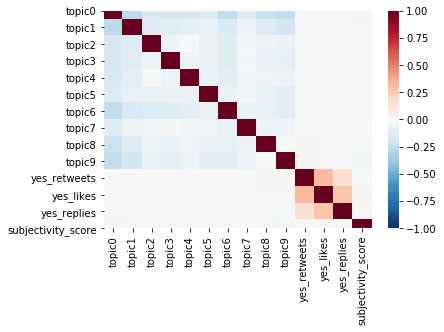

In [348]:
corr = main_df.corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu_r");

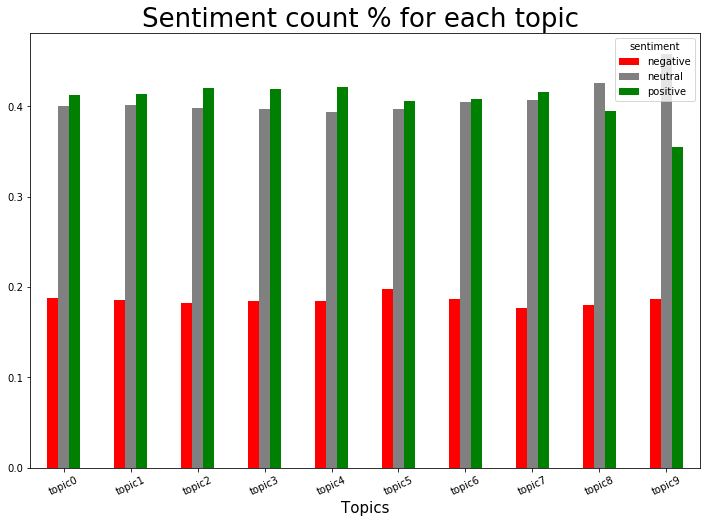

In [342]:
x = main_df.groupby("max_topic")["sentiment"].value_counts(normalize=True).unstack()
x.plot(kind = 'bar', figsize=(12,8), color =["red", "grey", "green"])
plt.title("Sentiment count % for each topic ", fontsize=26)
plt.xlabel("Topics", fontsize=15)
plt.xticks(rotation=25);

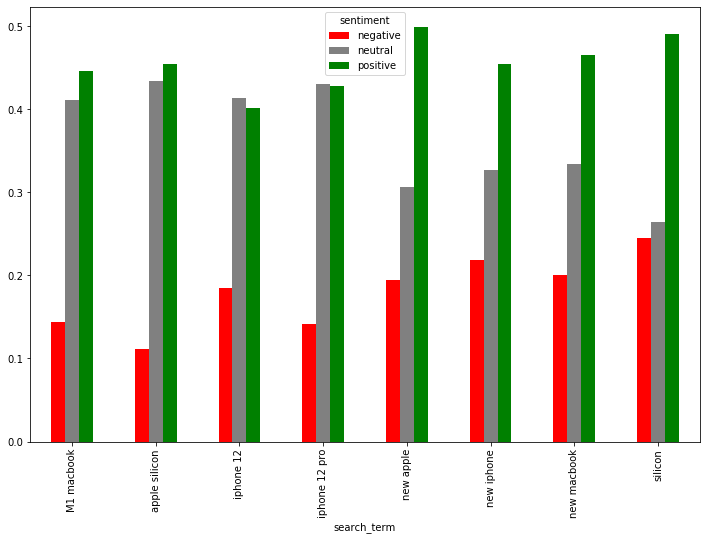

In [349]:
y = main.groupby("search_term")["sentiment"].value_counts(normalize=True).unstack()
y.plot(kind = 'bar', figsize=(12,8), color =["red", "grey", "green"]);

In [350]:
main.shape

(983566, 14)

In [358]:
main.search_term.value_counts()

new apple        247646
new iphone       220466
iphone 12        217309
silicon          167243
iphone 12 pro     93555
new macbook       25670
M1 macbook         9260
apple silicon      2417
Name: search_term, dtype: int64

In [298]:
main.groupby("search_term")["sentiment"].value_counts(normalize=True).unstack()

sentiment,negative,neutral,positive
search_term,,,
M1 macbook,0.143629,0.410907,0.445464
apple silicon,0.111295,0.434423,0.454282
iphone 12,0.185059,0.413241,0.401700
iphone 12 pro,0.142045,0.430057,0.427898
new apple,0.194887,0.306615,0.498498
new iphone,0.218387,0.327184,0.454428
new macbook,0.200701,0.333502,0.465797
silicon,0.245236,0.263868,0.490896


In [300]:
main.shape, main_df.shape

((983566, 14), (207196, 26))